# Credit Card Fraud Detection using an Autoencoder in TensorFlow

In [1]:
%matplotlib inline

In [2]:
from IPython.display import display
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import glob
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', palette='muted', font_scale=1.5, rc={'figure.figsize':(14, 8)})

# This is just to make TensorFlow use only one of my GPUs.
os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/dustin/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


First read in the data.  We'll be using a dataset from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud).  
Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015  

The data consists of a transaction time, several features that are the result of PCA transformations due to confidentiality issues, the transaction amount, and whether or not the transaction was fraudulent.

In [3]:
data = pd.read_csv('creditcard.csv')
display(data.head())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [5]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
LABELS = ['Non-Fraud', 'Fraud']

The data is very imbalanced.

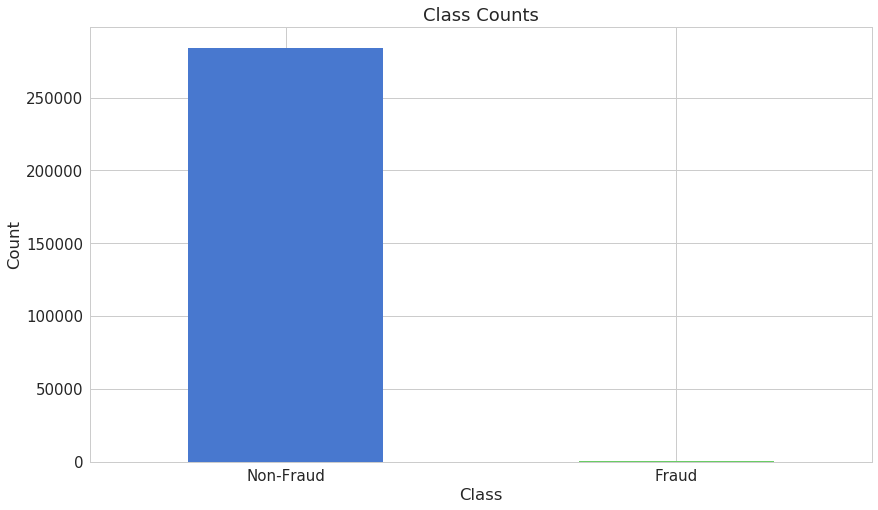

In [7]:
ax = data['Class'].value_counts().plot(kind='bar', rot=0)
ax.set_title('Class Counts');
ax.set_ylabel('Count');
ax.set_xlabel('Class');
ax.set_xticklabels(LABELS);

See if there is a difference in the amount distribution between fraudulent and non-fraudulent transactions.

In [8]:
non_frauds = data.loc[data['Class'] == 0]
frauds = data.loc[data['Class'] == 1]

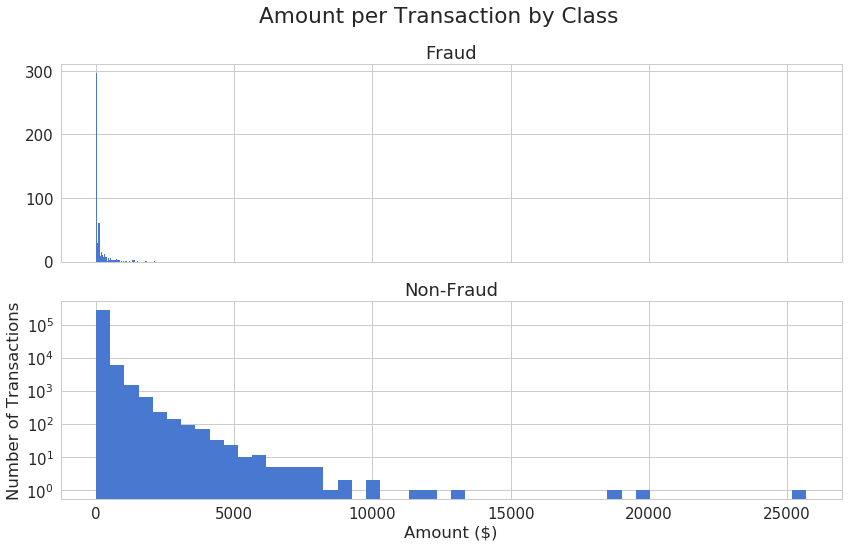

In [9]:
# Compare the distribution of amount by class.
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.suptitle('Amount per Transaction by Class')

bins = 50

ax1.hist(frauds['Amount'], bins=bins);
ax1.set_title('Fraud');

ax2.hist(non_frauds['Amount'], bins=bins);
ax2.set_title('Non-Fraud');
ax2.set_xlabel('Amount ($)');
ax2.set_ylabel('Number of Transactions');
ax2.set_yscale('log')

See if there is a pattern in the transaction time for fraudulent transactions.

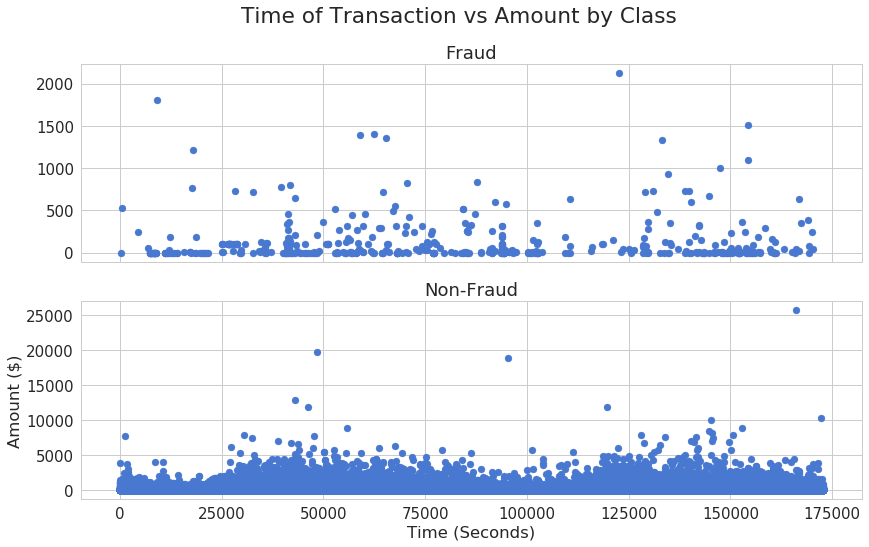

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of Transaction vs Amount by Class');

ax1.scatter(frauds['Time'], frauds['Amount']);
ax1.set_title('Fraud');

ax2.scatter(non_frauds['Time'], non_frauds['Amount']);
ax2.set_title('Non-Fraud');
ax2.set_xlabel('Time (Seconds)');
ax2.set_ylabel('Amount ($)');

Get the data ready to run through the autoencoder.  Throw away the transaction time because there doesn't seem to be a pattern between it and fraudulent transactions.  Normalize the amount and split the dataset into train and test.  Since this is an autoencoder, labels are not used for training.

In [11]:
data = data.drop(columns=['Time'])
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [12]:
train_features, test_features = train_test_split(data, test_size=0.2)
train_features = train_features[train_features['Class'] == 0]
train_features = train_features.drop(columns=['Class'])

test_labels = test_features['Class']
test_features = test_features.drop(columns=['Class'])

display(train_features.shape)
display(test_features.shape)

(227454, 29)

(56962, 29)

## TensorFlow Implementation

### Define the Feature Columns
These are all numeric value columns so this is easy.

In [13]:
def get_feature_columns(features):
    return [tf.feature_column.numeric_column(key=c) for c in features.columns]

### Define the input pipelines

In [14]:
def train_input_fn():
    return tf.estimator.inputs.pandas_input_fn(x=train_features, y=None, num_epochs=100, batch_size=32, shuffle=True)
    

def test_input_fn():
    return tf.estimator.inputs.pandas_input_fn(x=test_features, y=None, batch_size=1000000, shuffle=False)

### Define the autoencoder model
It's really just a regular neural network that funnels down into a small number of hidden units in the middle and then back up to the original number of features - which effectively forces the network to generalize and "denoise" the data.

In [15]:
def create_autoencoder_model(features, labels, mode, params):
    input_layer = tf.feature_column.input_layer(features, params['feature_columns'])
    
    hidden_layer = input_layer
    for layer_index, layer_size in enumerate(params['hidden_layers']):
        hidden_layer = tf.layers.dense(hidden_layer, 
                                       units=layer_size, 
                                       activation=params['activation_function'], 
                                       name='Hidden{0}'.format(layer_index))
    
    output_layer = tf.layers.dense(hidden_layer, units=len(features), name='OutputLayer')
    
    # If predict, there is nothing else to add to the graph.
    if mode == tf.estimator.ModeKeys.PREDICT:
        estimator_spec = tf.estimator.EstimatorSpec(mode, predictions=output_layer)
    # If eval or train there are some more pieces to add to the graph.    
    else:
        loss = tf.losses.mean_squared_error(labels=input_layer, predictions=output_layer, reduction=tf.losses.Reduction.MEAN)
        
        if mode == tf.estimator.ModeKeys.EVAL:
            estimator_spec = tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=None)
        else:
            optimizer = tf.train.AdamOptimizer(learning_rate=params['learning_rate'])
            train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
            estimator_spec = tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)
        
    return estimator_spec

### Train
I have a rudimentary grid to test different learning rates and activation functions.  Notice the hidden_layers of [14, 7, 14].  We start with 29 features and funnel that down to 14 and then 7.  Then we bring it back up to 14 and then 29.  So the model is forced to sort of compress and generalize the data and then recreate what it started with with that generalized data.

In [16]:
%%time

tf.logging.set_verbosity('WARN')
input_fn = train_input_fn()
feature_columns = get_feature_columns(train_features)
hidden_layers = [14, 7, 14]

learning_rates = [0.01, 0.001, 0.0001]
activation_functions = [tf.nn.tanh, tf.nn.relu]

run_number = 0
for learning_rate in learning_rates:
    for activation_function in activation_functions:
        run_name = 'run_{0}'.format(run_number)
        print('{0}: learning_rate {1}, activation_function{2}'.format(run_name, learning_rate, activation_function))
        
        
        filelist = glob.glob('./model/{0}/*'.format(run_name))
        for file in filelist:
            os.remove(file)
        
        autoencoder = tf.estimator.Estimator(model_fn=create_autoencoder_model,
                                             model_dir='./model/{0}'.format(run_name),
                                             params={'feature_columns': feature_columns,
                                                     'hidden_layers': hidden_layers,
                                                     'activation_function': activation_function,
                                                     'learning_rate': learning_rate})
        
        autoencoder.train(input_fn=input_fn);
        
        run_number = run_number + 1

run_0: learning_rate 0.01, activation_function<function tanh at 0x7f2d35a05488>
run_1: learning_rate 0.01, activation_function<function relu at 0x7f2d35a99048>
run_2: learning_rate 0.001, activation_function<function tanh at 0x7f2d35a05488>
run_3: learning_rate 0.001, activation_function<function relu at 0x7f2d35a99048>
run_4: learning_rate 0.0001, activation_function<function tanh at 0x7f2d35a05488>
run_5: learning_rate 0.0001, activation_function<function relu at 0x7f2d35a99048>
CPU times: user 4h 8min 33s, sys: 9min 34s, total: 4h 18min 8s
Wall time: 2h 38min 47s


The model with a learning rate of 0.001 and relu activation function performed well so we'll train the model for those hyperparameters.

In [17]:
%%time

tf.logging.set_verbosity('WARN')
input_fn = train_input_fn()
feature_columns = get_feature_columns(train_features)
hidden_layers = [14, 7, 14]
activation_function = tf.nn.relu
learning_rate = 0.001
run_name = 'relu001'

filelist = glob.glob('./model/{0}/*'.format(run_name))
for file in filelist:
    os.remove(file)
    
autoencoder = tf.estimator.Estimator(model_fn=create_autoencoder_model,
                                 model_dir='./model/{0}'.format(run_name),
                                 params={'feature_columns': feature_columns,
                                         'hidden_layers': hidden_layers,
                                         'activation_function': activation_function,
                                         'learning_rate': learning_rate})
        
autoencoder.train(input_fn=input_fn);

CPU times: user 41min 25s, sys: 1min 36s, total: 43min 1s
Wall time: 26min 25s


### Predict
With the luxury of having the labels, we can see if the autoencoder is any good for detecting frauds.  To do this, we can run the test set through the trained model and compare the original data to the resulting data by calculating the error between between the two sets.  The error between the two sets is sort of a measure of how far from "normal" the example is and the result we are hoping for is that the fraudulent transactions are picked up within these abnormal transactions.

In [18]:
predictions = np.array(list(autoencoder.predict(input_fn=test_input_fn())))

In [19]:
predictions.shape

(56962, 29)

In [20]:
errors = np.mean(np.power(test_features.values - predictions, 2), axis=1)
results = pd.DataFrame({'error': errors, 'class': test_labels})
results.describe()

,class,error
count,56962.000000,56962.000000
mean,0.001773,1.948332
std,0.042071,7.281702
min,0.000000,0.264328
25%,0.000000,0.721857
50%,0.000000,1.051340
75%,0.000000,1.696571
max,1.000000,501.340981


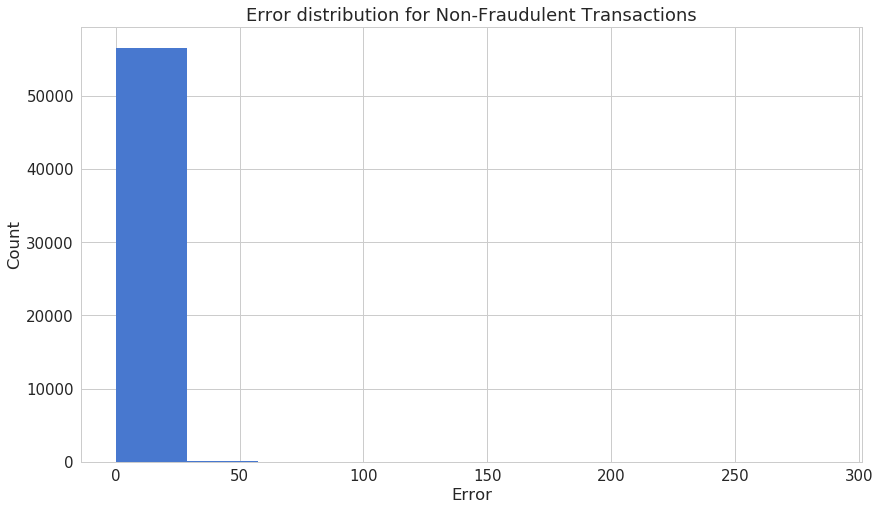

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
non_frauds = results.loc[(results['class'] == 0) & (results['error'] < 300)]
ax.hist(non_frauds['error'].values, bins=10);
ax.set_title('Error distribution for Non-Fraudulent Transactions')
ax.set_ylabel('Count');
ax.set_xlabel('Error');

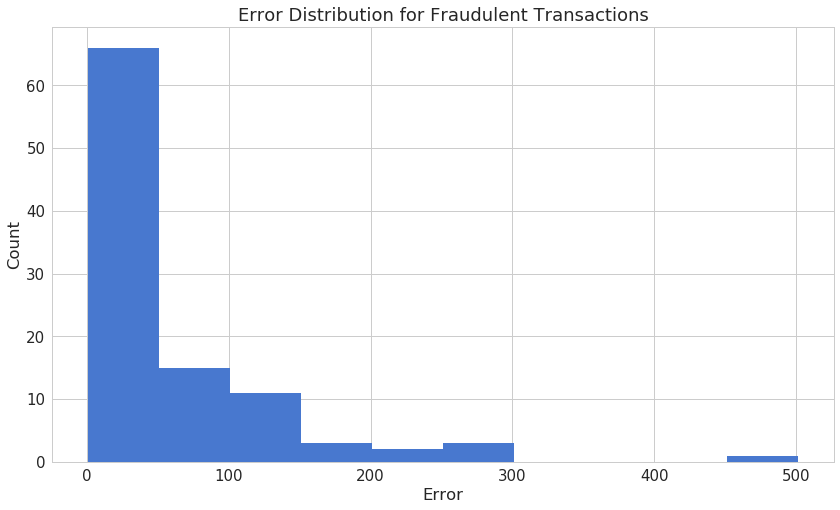

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
frauds = results.loc[results['class'] == 1]
ax.hist(frauds['error'].values, bins=10);
ax.set_title('Error Distribution for Fraudulent Transactions')
ax.set_ylabel('Count');
ax.set_xlabel('Error');